# Recurrent Neural Network 
## Temperature-Forecasting using Numpy

[References]
- [LSTM Forecasting](https://www.crosstab.io/articles/time-series-pytorch-lstm/)
- [PyTorch RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)
- [PyTorch LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

In [32]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

from torchinfo import summary

from data_preprocess import X, y, num_train_samples, num_val_samples, num_test_samples

import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
num_features = X.shape[1]
print('Number of features:', num_features)

Number of features: 14


## Data Loader

In [4]:
# Observations will be sampled at one data point per hour
sampling_rate=6

# Observations will go back 5 days (120 hours)
sequence_length = 120

# The target for a sequence will be the temperature 24 hours after the end of the sequence.
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

class SequenceDataset(Dataset):
    def __init__(self, X_array, y_array, sampling_rate, sequence_length, delay):
        super(Dataset, self).__init__()

        self.sr = sampling_rate
        self.seq_len = sequence_length
        self.delay = delay
        self.X = torch.tensor(X_array).float()
        self.y = torch.tensor(y_array).float()

    def __len__(self):
        return self.X.size(0) - self.delay

    def __getitem__(self, i): 
        idx = np.arange(i, i+self.sr*self.seq_len, self.sr)
        return self.X[idx], self.y[i+self.delay]

In [5]:
train_dataset = SequenceDataset(X[:num_train_samples], 
                                y[:num_train_samples], 
                                sampling_rate=sampling_rate, sequence_length=sequence_length,
                                delay = delay)

valid_dataset = SequenceDataset(X[num_train_samples:num_train_samples+num_val_samples], 
                                y[num_train_samples:num_train_samples+num_val_samples], 
                                sampling_rate=sampling_rate, sequence_length=sequence_length,
                                delay = delay)

test_dataset = SequenceDataset(X[-num_test_samples:],
                               y[-num_test_samples:], 
                               sampling_rate=sampling_rate, sequence_length=sequence_length,
                               delay = delay)


In [6]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
for samples, targets in train_loader:
    print('samples shape:', samples.shape)
    print('targets shape:', targets.shape)
    break

samples shape: torch.Size([256, 120, 14])
targets shape: torch.Size([256])


In [8]:
def train(model, trainloader, validloader, criterion, optimizer, epoch, device):
    
    losses = []
    val_losses = []
    model.to(device)
    model.train()

    for i in range(1, epoch+1):
        count = 0
        train_loss = 0
        for X, y in tqdm(trainloader):
            X = X.to(device)
            y = y.to(device)

            output = model(X).view(-1)
            loss = criterion(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            count += 1

        train_loss /= count
        losses.append(train_loss)

        count = 0
        valid_loss = 0
        with torch.no_grad():
            for X, y in validloader:
                X = X.to(device)
                y = y.to(device)

                output = model(X).view(-1)
                loss = criterion(output, y)
                valid_loss += loss.item()
                count += 1
            
        valid_loss /= count
        val_losses.append(valid_loss)

        print('EPOCH %d Completed. \n Training Loss: %.3f, Validation Loss: %.3f \n' 
              %(i, train_loss, valid_loss))

    return losses, val_losses

In [9]:
def test(model, evalloader, criterion, device):
    eval_loss = 0
    count = 0
    model.eval()
    predictions = np.empty([0])

    with torch.no_grad():
        for X, y in evalloader:
            X = X.to(device)
            y = y.to(device)

            output = model(X).view(-1)
            predictions = np.append(predictions, output.numpy())

            loss = criterion(output, y)
            eval_loss += loss.item()
            count += 1
        
    eval_loss /= count
    
    return predictions, eval_loss

## RNN models

### SimpleRNN

[Reference: 오승상 딥러닝](https://youtube.com/playlist?list=PLvbUC2Zh5oJvByu9KL82bswYT2IKf0K1M)
![SimpleRNN](SimpleRNN.png)

In [30]:
print('The number of features:', num_features)
print('The sequence length:', sequence_length)

The number of features: 14
The sequence length: 120


**Note: An RNN layer is capable of processing sequences of any length.**

- Clearly, sequence dataset of arbitrary length cannot be trained using minibatch, i.e., we should set `batch_size=1`.


In [10]:
class RNN_model(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN_model, self).__init__()

        self.hidden_size = hidden_size

        self.rnn = nn.RNN(input_size  = input_size,
                          hidden_size = hidden_size,
                          num_layers  = 1,              # The number of stacked RNN layers
                          batch_first = True            # Default: False
                        )
        self.linear = nn.Linear(in_features = hidden_size, 
                                out_features=1, 
                                bias=True
                            )

    def forward(self, x):
        output, h_n = self.rnn(x)
        '''
        output size : (batch_size, sequence_length, hidden_size)
        -> hidden state vectors for each time step.
        h_n : (num_layers, batch_size, hidden_size)
        '''
        h_n = h_n.view(-1, self.hidden_size)
        '''
        Reshape to (batch_size, hidden_size) : appropriate shape as linear layer input
        '''
        x = self.linear(h_n)
        return x

In [12]:
SimpleRNN = RNN_model(input_size=num_features, hidden_size=16).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(SimpleRNN.parameters(), lr=1e-3)
EPOCHS = 10

In [33]:
summary(SimpleRNN, (batch_size, sequence_length, num_features))

Layer (type:depth-idx)                   Output Shape              Param #
RNN_model                                [256, 1]                  --
├─RNN: 1-1                               [256, 120, 16]            512
├─Linear: 1-2                            [256, 1]                  17
Total params: 529
Trainable params: 529
Non-trainable params: 0
Total mult-adds (M): 15.73
Input size (MB): 1.72
Forward/backward pass size (MB): 3.93
Params size (MB): 0.00
Estimated Total Size (MB): 5.66

#### Let's check the number of parameters in RNN using PyTorch

- `num_features = 14` $\quad \to \quad$ dimension of $x_t$
- `hidden_state = 16` $\quad \to \quad$ dimension of $h_t$

**Computation of RNN core** : 
$h_t = \tanh(x_tW_{ih}^T + b_{ih} + h_{t-1} W_{hh}^T + b_{hh}) $

- $W_{ih}$ size : 16 $\times$ 14
- $W_{hh}$ size : 16 $\times$ 16
- $b_{ih}$ size : 16
- $b_{hh}$ size : 16
- Total : $16 \times 14 + 16 \times 16 + 16 + 16 = (14+16+2) \times 16 = 512$

In [13]:
train_loss, val_loss = train(SimpleRNN, train_loader, valid_loader, criterion, optimizer, EPOCHS, device)

100%|██████████| 983/983 [00:25<00:00, 38.10it/s]


EPOCH 1 Completed. 
 Training Loss: 51.424, Validation Loss: 15.643 



100%|██████████| 983/983 [00:26<00:00, 37.36it/s]


EPOCH 2 Completed. 
 Training Loss: 14.512, Validation Loss: 10.989 



100%|██████████| 983/983 [00:27<00:00, 36.09it/s]


EPOCH 3 Completed. 
 Training Loss: 11.147, Validation Loss: 10.404 



100%|██████████| 983/983 [00:27<00:00, 35.35it/s]


EPOCH 4 Completed. 
 Training Loss: 10.433, Validation Loss: 10.008 



100%|██████████| 983/983 [00:28<00:00, 34.18it/s]


EPOCH 5 Completed. 
 Training Loss: 10.118, Validation Loss: 9.872 



100%|██████████| 983/983 [00:28<00:00, 34.90it/s]


EPOCH 6 Completed. 
 Training Loss: 9.974, Validation Loss: 9.933 



100%|██████████| 983/983 [00:29<00:00, 33.04it/s]


EPOCH 7 Completed. 
 Training Loss: 9.887, Validation Loss: 9.825 



100%|██████████| 983/983 [00:32<00:00, 29.93it/s]


EPOCH 8 Completed. 
 Training Loss: 9.814, Validation Loss: 9.768 



100%|██████████| 983/983 [00:30<00:00, 32.37it/s]


EPOCH 9 Completed. 
 Training Loss: 9.738, Validation Loss: 9.781 



100%|██████████| 983/983 [00:29<00:00, 33.47it/s]


EPOCH 10 Completed. 
 Training Loss: 9.667, Validation Loss: 9.800 



In [14]:
predictions, eval_loss = test(SimpleRNN, test_loader, criterion, device)

In [15]:
test_targets = np.empty([0])

for X, y in test_loader:
    test_targets = np.append(test_targets, y.numpy())

test_num = test_targets.shape[0]
print(test_num)

83233


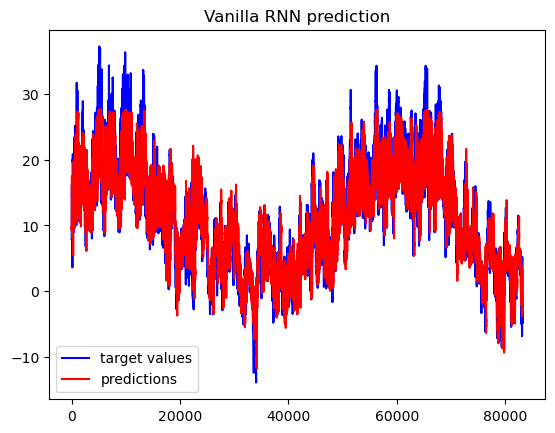

In [16]:
x = np.arange(test_num)
plt.plot(x, test_targets, label = 'target values', color='b')
plt.plot(x, predictions, label = 'predictions', color='r')
plt.title('Vanilla RNN prediction')
plt.legend()
plt.show()

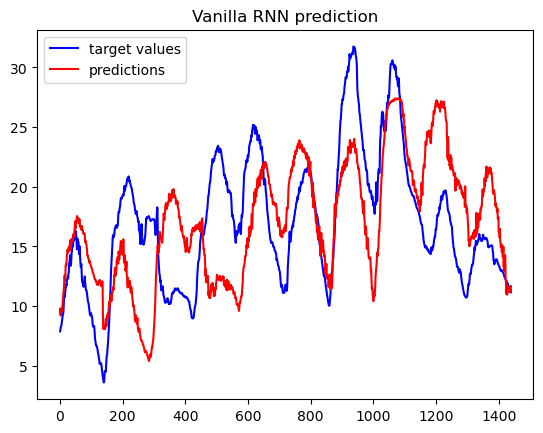

In [17]:
x = np.arange(1440)
plt.plot(x, test_targets[:1440], label = 'target values', color='b')
plt.plot(x, predictions[:1440], label = 'predictions', color='r')
plt.title('Vanilla RNN prediction')
plt.legend()
plt.show()

### Stacked RNN

In [18]:
class Stacked_RNN_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super(Stacked_RNN_model, self).__init__()

        self.hidden_size = hidden_size

        self.rnn = nn.RNN(input_size  = input_size,
                          hidden_size = hidden_size,
                          num_layers  = num_layers,     # The number of stacked RNN layers
                          batch_first = True            # Default: False
                        )
        self.linear = nn.Linear(in_features = hidden_size, 
                                out_features=1, 
                                bias=True
                            )

    def forward(self, x):
        output, h_n = self.rnn(x)
        '''
        output size : (batch_size, sequence_length, num_layers * hidden_size)
        -> hidden state vectors for each time step, for each layer.
        h_n : (num_layers, batch_size, hidden_size)
        '''
        h_n = h_n[1,:,:].view(-1, self.hidden_size)
        '''
        The final hidden state of the second rnn layer
        and reshaped to (batch_size, hidden_size)
        '''
        x = self.linear(h_n)
        return x

In [19]:
StackedRNN = Stacked_RNN_model(input_size=num_features, hidden_size=16, num_layers=2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(StackedRNN.parameters(), lr=1e-3)
EPOCHS = 10

In [34]:
summary(StackedRNN, (batch_size, sequence_length, num_features))

Layer (type:depth-idx)                   Output Shape              Param #
Stacked_RNN_model                        [256, 1]                  --
├─RNN: 1-1                               [256, 120, 16]            1,056
├─Linear: 1-2                            [256, 1]                  17
Total params: 1,073
Trainable params: 1,073
Non-trainable params: 0
Total mult-adds (M): 32.44
Input size (MB): 1.72
Forward/backward pass size (MB): 3.93
Params size (MB): 0.00
Estimated Total Size (MB): 5.66

**You should try to check the number of parameters in the RNN layer!**

In [20]:
train_loss2, val_loss2 = train(StackedRNN, train_loader, valid_loader, criterion, optimizer, EPOCHS, device)

100%|██████████| 983/983 [00:53<00:00, 18.45it/s]


EPOCH 1 Completed. 
 Training Loss: 57.047, Validation Loss: 17.675 



100%|██████████| 983/983 [00:55<00:00, 17.75it/s]


EPOCH 2 Completed. 
 Training Loss: 15.639, Validation Loss: 11.319 



100%|██████████| 983/983 [00:55<00:00, 17.83it/s]


EPOCH 3 Completed. 
 Training Loss: 11.231, Validation Loss: 10.250 



100%|██████████| 983/983 [00:51<00:00, 19.21it/s]


EPOCH 4 Completed. 
 Training Loss: 10.183, Validation Loss: 9.872 



100%|██████████| 983/983 [00:51<00:00, 19.01it/s]


EPOCH 5 Completed. 
 Training Loss: 9.803, Validation Loss: 9.759 



100%|██████████| 983/983 [00:46<00:00, 21.10it/s]


EPOCH 6 Completed. 
 Training Loss: 9.506, Validation Loss: 9.699 



100%|██████████| 983/983 [00:48<00:00, 20.31it/s]


EPOCH 7 Completed. 
 Training Loss: 9.281, Validation Loss: 9.629 



100%|██████████| 983/983 [00:47<00:00, 20.90it/s]


EPOCH 8 Completed. 
 Training Loss: 9.098, Validation Loss: 9.689 



100%|██████████| 983/983 [00:46<00:00, 21.15it/s]


EPOCH 9 Completed. 
 Training Loss: 8.982, Validation Loss: 9.774 



100%|██████████| 983/983 [00:48<00:00, 20.27it/s]


EPOCH 10 Completed. 
 Training Loss: 8.849, Validation Loss: 9.696 



In [21]:
predictions2, eval_loss2 = test(StackedRNN, test_loader, criterion, device)

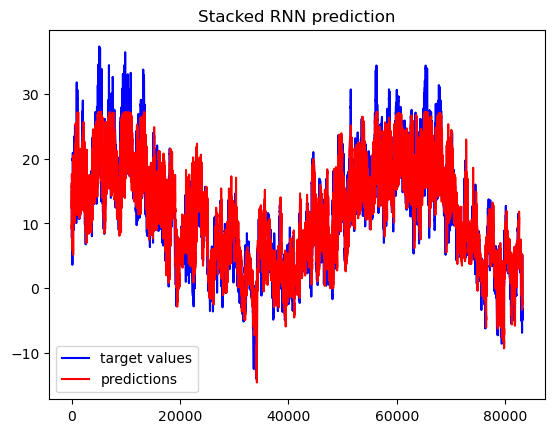

In [22]:
x = np.arange(test_num)
plt.plot(x, test_targets, label = 'target values', color='b')
plt.plot(x, predictions2, label = 'predictions', color='r')
plt.title('Stacked RNN prediction')
plt.legend()
plt.show()

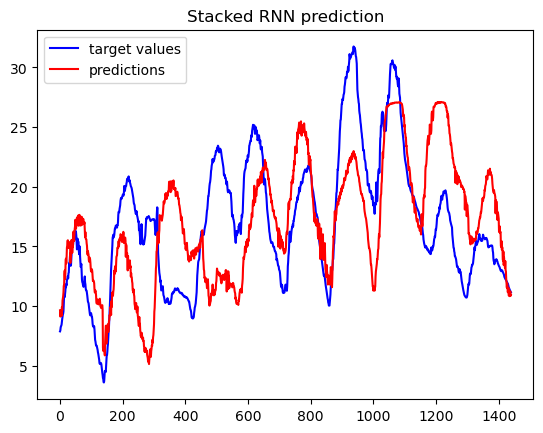

In [23]:
x = np.arange(1440)
plt.plot(x, test_targets[:1440], label = 'target values', color='b')
plt.plot(x, predictions2[:1440], label = 'predictions', color='r')
plt.title('Stacked RNN prediction')
plt.legend()
plt.show()

### LSTM 

[Reference: 오승상 딥러닝](https://youtube.com/playlist?list=PLvbUC2Zh5oJvByu9KL82bswYT2IKf0K1M)
![LSTM](LSTM.png)

In [24]:
class LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM_model, self).__init__()

        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size  = input_size,
                            hidden_size = hidden_size,
                            num_layers  = 1,     # The number of stacked RNN layers
                            batch_first = True            # Default: False
                            )
        self.linear = nn.Linear(in_features = hidden_size, 
                                out_features=1, 
                                bias=True
                                )

    def forward(self, x):
        output, (h_n, c_n) = self.lstm(x)
        '''
        output size : (batch_size, sequence_length, num_layers * hidden_size)
        -> hidden state vectors (NOT CELL STATE VECTORS) for each time step, for each layer.
        h_n : (num_layers, batch_size, hidden_size) 
        c_n : (num_layers, batch_size, hidden_size)
        '''
        h_n = h_n.view(-1, self.hidden_size)
        '''
        Reshape to (batch_size, hidden_size) : appropriate shape as linear layer input
        '''
        x = self.linear(h_n)
        return x

In [25]:
LSTM = LSTM_model(input_size=num_features, hidden_size=16).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(LSTM.parameters(), lr=1e-3)
EPOCHS = 10

In [36]:
summary(LSTM, (batch_size, sequence_length, num_features))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM_model                               [256, 1]                  --
├─LSTM: 1-1                              [256, 120, 16]            2,048
├─Linear: 1-2                            [256, 1]                  17
Total params: 2,065
Trainable params: 2,065
Non-trainable params: 0
Total mult-adds (M): 62.92
Input size (MB): 1.72
Forward/backward pass size (MB): 3.93
Params size (MB): 0.01
Estimated Total Size (MB): 5.66

#### Let's check the number of parameters in LSTM

- `num_features = 14` $\quad \to \quad$ dimension of $x_t$
- `hidden_state = 16` $\quad \to \quad$ dimension of $h_t$
- `cell_state = 16` $\quad \to \quad$ dimension of $c_t$

**Computation in an LSTM cell**

- $i_t = \sigma(W_{xh}^i x_t + b_x^i + W_{hh}^i h_{t-1} + b_h^i)$ : input gate
- $f_t = \sigma(W_{xh}^f x_t + b_x^f + W_{hh}^f h_{t-1} + b_h^f)$ : forget gate
- $o_t = \sigma(W_{xh}^o x_t + b_x^o + W_{hh}^o h_{t-1} + b_h^o)$ : output gate
- $g_t = \tanh(W_{xh}^g x_t + b_x^g + W_{hh}^g h_{t-1} + b_h^g)$ : RNN core

*Total number of parameters*
- each of $W_{xh}$ size : 14 $\times$ 16
- each of $W_{hh}$ size : 16 $\times$ 16
- each of $b_h$ and $b_x$ size : 16
- Total : $4\times (14 \times 16 + 16 \times 16 + 16 + 16) = 4 \times (14+16+2) \times 16 = 2048$

In [26]:
train_loss3, val_loss3 = train(LSTM, train_loader, valid_loader, criterion, optimizer, EPOCHS, device)

100%|██████████| 983/983 [01:02<00:00, 15.63it/s]


EPOCH 1 Completed. 
 Training Loss: 56.504, Validation Loss: 16.202 



100%|██████████| 983/983 [01:02<00:00, 15.68it/s]


EPOCH 2 Completed. 
 Training Loss: 15.271, Validation Loss: 11.219 



100%|██████████| 983/983 [01:00<00:00, 16.38it/s]


EPOCH 3 Completed. 
 Training Loss: 11.080, Validation Loss: 10.080 



100%|██████████| 983/983 [01:00<00:00, 16.22it/s]


EPOCH 4 Completed. 
 Training Loss: 9.879, Validation Loss: 9.825 



100%|██████████| 983/983 [01:02<00:00, 15.72it/s]


EPOCH 5 Completed. 
 Training Loss: 9.540, Validation Loss: 9.489 



100%|██████████| 983/983 [01:03<00:00, 15.48it/s]


EPOCH 6 Completed. 
 Training Loss: 9.221, Validation Loss: 9.637 



100%|██████████| 983/983 [00:58<00:00, 16.88it/s]


EPOCH 7 Completed. 
 Training Loss: 8.929, Validation Loss: 9.708 



100%|██████████| 983/983 [01:00<00:00, 16.14it/s]


EPOCH 8 Completed. 
 Training Loss: 8.726, Validation Loss: 9.568 



100%|██████████| 983/983 [01:00<00:00, 16.30it/s]


EPOCH 9 Completed. 
 Training Loss: 8.480, Validation Loss: 9.433 



100%|██████████| 983/983 [01:03<00:00, 15.55it/s]


EPOCH 10 Completed. 
 Training Loss: 8.264, Validation Loss: 9.575 



In [27]:
predictions3, eval_loss3 = test(LSTM, test_loader, criterion, device)

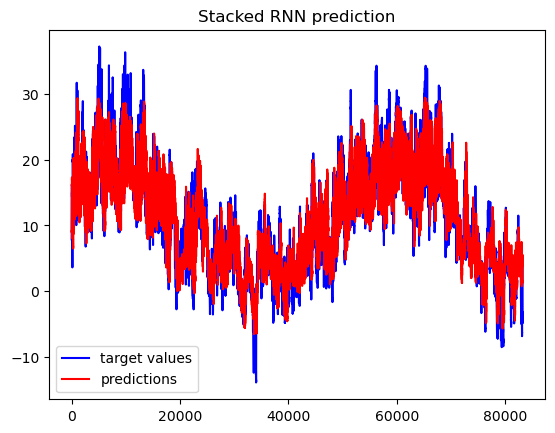

In [28]:
x = np.arange(test_num)
plt.plot(x, test_targets, label = 'target values', color='b')
plt.plot(x, predictions3, label = 'predictions', color='r')
plt.title('Stacked RNN prediction')
plt.legend()
plt.show()

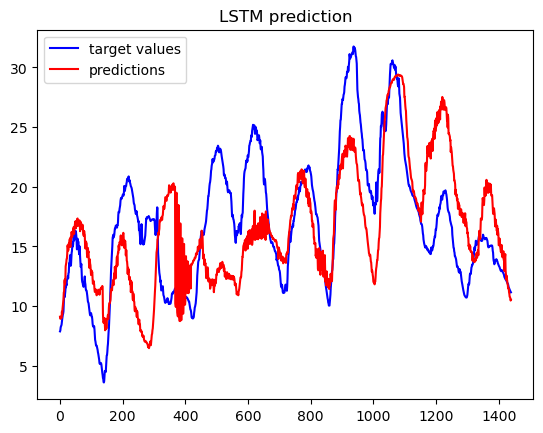

In [29]:
x = np.arange(1440)
plt.plot(x, test_targets[:1440], label = 'target values', color='b')
plt.plot(x, predictions3[:1440], label = 'predictions', color='r')
plt.title('LSTM prediction')
plt.legend()
plt.show()

## Future Works

- Bidirectional RNN
- Stacked LSTM
- GRU